In [1]:
#!pip install holidays 
#!pip install xgboost
#!pip install bayesian-optimization

In [2]:
import pandas as pd
from itertools import *
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import numpy as np
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
from collections import Counter
import ast
import gc
import datetime
import holidays
from datetime import date
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy.stats import pearsonr
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import accuracy_score, mean_squared_error
from xgboost import XGBClassifier
from xgboost.sklearn import XGBRegressor
from math import sqrt
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
import lightgbm as lgb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import gc

In [3]:
##basic information about data 

main_data = pd.read_csv("Movie_Revenue_predictions.csv", parse_dates=['release_date'])
## Missing Values 


x = datetime.datetime(2015, 1, 4)
main_data.loc[main_data['id'] == 380097,'release_date'] = x
main_data.loc[main_data['id'] == 370980,'runtime'] = 113
main_data.loc[main_data['id'] == 459488,'runtime'] = 81
main_data.loc[main_data['id'] == 370980,'overview'] = "The life of Jorge Mario Bergoglio, from his youth to his election as head of the Roman Catholic Church."
main_data.loc[main_data['id'] == 459488,'overview'] = "An exploration of how singer and actor Frank Sinatra became one of the biggest stars of the 20th century while remaining, in his heart, a normal person."
main_data.loc[main_data['id'] == 292539,'overview'] = "Farmworkers in Immokalee, Fla., launch a hunger strike at the headquarters of Publix supermarkets to protest poor wages and working conditions."
main_data.loc[main_data['id'] == 19,'budget'] = 5300000
main_data.loc[main_data['id'] == 408,'revenue'] = 6500000
#we have successfully filled the missing values in release date, runtime and overview column 

print("\n\n")
print(main_data.isnull().sum()) ## now we only have two features with missing value





title                      0
tagline                  844
revenue                    0
budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
overview                   0
production_companies       0
production_countries       0
release_date               0
runtime                    0
spoken_languages           0
status                     0
dtype: int64


we also have missing values in release date,runtime and overview column. so lets manually impute those values.

**Feature Engineering**

In [4]:
def feature_engineering(df):
   
    
    ##lets correct the release date and extract year, month, day and day of week in separate columns
    def correcting_dates(df):    
        df['release_year'] = df['release_date'].dt.year
        df['release_month'] = df['release_date'].dt.month
        df['release_day'] = df['release_date'].dt.day
        df['release_quarter'] = df['release_date'].dt.quarter
        df.drop(columns=['release_date'], inplace=True)
        df['release_year']=np.where(df['release_year']> 2019, df['release_year']-100, df['release_year'])
        year = df["release_year"].astype(int).copy().astype(str)
        month=df['release_month'].astype(int).copy().astype(str)
        day=df['release_day'].astype(int).copy().astype(str) 
        df["release_date"]=  month.str.cat(day.str.cat(year,sep="/"), sep ="/") 
        df['release_date']=pd.to_datetime(df['release_date'],format="%m/%d/%Y")
        df['release_dow'] = df['release_date'].dt.dayofweek
        return df
    
    df = correcting_dates(df)
    
    ## title
    df['title_word_count'] = df['title'].str.split().str.len()
    
    ##for genres column
    
    df['genres'] = df['genres'].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    df['num_genres'] = df['genres'].apply(lambda x: len(x) if x != {} else 0) #summation of number of genres
    df['all_genres'] = df['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '') #all possible genres in one column\
    list_of_genres = list(df['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values) ##list of all genres in every row #20
    top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common()] #we may create more sparse data using all genre
    for g in top_genres:
        
        df[ g + '_genre'] = df['all_genres'].apply(lambda x: 1 if g in x else 0)
        
        
    
    
    ## homepage
    df['has_homepage'] = 1
    df.loc[pd.isnull(df['homepage']) ,"has_homepage"] = 0
    
    
    
    ## tagline
    df['isTaglineNA'] = 0
    df.loc[df['tagline'] == 0 ,"isTaglineNA"] = 1
    df['tagline_word_count'] = df['tagline'].str.split().str.len()
    
    
    
    
    
    ##original language
    df['eng_language'] = 0 
    df.loc[ df['original_language'] == "en" ,'eng_language'] = 1
    
    
    
    ##overview
    df['overview_word_count'] = df['overview'].str.split().str.len()
    
    
    ##production companies
    df['num_production_companies'] = df['production_companies'].apply(lambda x: len(x) if x != {} else 0)
    
    
    
    ## production countries
    df['num_production_countries'] = df['production_countries'].apply(lambda x: len(x) if x != {} else 0)
    
    ## spoken languages
    df['num_spoken_languages'] = df['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
    
    
    
    ## extra features
    df['meanruntimebyyear'] = df.groupby("release_year")["runtime"].transform('mean')
    
    
    
    ## number of clashes
    
    hit_movies = df[df['revenue'] >=  df.revenue.quantile(0.60)] #38 million
    hit_movies_dates = list(hit_movies['release_date'])
    hit_movies_title = list(hit_movies['title'])
    upp = pd.Timedelta('15 days')
    low = pd.Timedelta('-15 days')
    same = pd.Timedelta('0 days')
    
    def number_of_clashes(row):
        if row['title'] in hit_movies_title:
            a = 0
            return a
        else:

            for i in hit_movies_dates:
                ans = row['release_date'] - i
                num_clashes = 0
                if low <= ans <= upp:
                    num_clashes += 1
                else:
                    num_clashes += 0
                return num_clashes
    
    df['Num_clash'] = df.apply(lambda row : number_of_clashes(row), axis=1)
    
    
    
    ## binned release year into decades (binning helps)
    
    bins = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
    labels = [1,2,3,4,5,6,7,8,9,10]
    df['binned_release_year'] = pd.cut(df['release_year'], bins=bins, labels=labels)
    
    
    ## BUDGET ##########################
    ## there are 1037 missing budget in our dataset. lets fill that mean budget value by year
    
    mean_budget_year = df.groupby("release_year")["budget"].mean()
    
    '''
    def filling_zero(row):
        if row['budget'] == 0:
            year = row['release_year']
            ans = mean_budget_year[year]
            return ans
        else:
            ans = row['budget']
            return ans
    df['budget'] = df.apply(lambda row : filling_zero(row), axis=1)
    
    '''
    df.drop([4255], inplace = True) ## this row was causing a problem. 
    df['meanbudgetbyyear'] = df.groupby("release_year")["budget"].transform('mean')
    df['medianbudgetbyyear'] = df.groupby("release_year")["budget"].transform('median')

    #now binning budget
    bins = list(range(0,380000000, 5000000)) #1 bin = 5 mil
    labels = list(range(1,76,1))
    df['binned_budget'] = pd.cut(df['budget'], bins=bins, labels=labels)
    
    ##inflation budget over a year, so we will see rise in mean year budget with respect to first year mean budget in our dataset
    df['inflated_budget_year'] = df.apply(lambda row : (row['meanbudgetbyyear'] - 245000)/row['meanbudgetbyyear'] , axis=1)
    
    ##inflation budget over a decade, so we will see rise in mean decade budget with respect to first decade mean budget
    df['meanbudgetbydecade'] = df.groupby("binned_release_year")["budget"].transform('mean')
    df['inflated_budget_decade'] = df.apply(lambda row : (row['meanbudgetbydecade'] - 19514600)/row['meanbudgetbydecade'] , axis=1)
    
    ## inflation budget by last year
    def inflated_budget_last_year(row):
        if row['release_year'] == 1925:
            return 0
        elif row['release_year'] == 1927 or 1929 or 1932:
            return 1
        else:
            mean_budget_last_year = mean_budget_year(row['release_year'] - 1)
            ans = (row['meanbudgetbyyear'] - mean_budget_last_year) / row['meanbudgetbyyear']
            return ans
            
            
    
    df['inflation_last_year'] = df.apply(lambda row : inflated_budget_last_year(row), axis=1)
    
    
    
    ## budget year ratio
    df['budget_year_ratio'] = df['budget'] / (df['release_year'] * df['release_year'])
    
    ##budget runtime ratio
    df['budget_to_runtime'] = df['budget'] / df['runtime']
    
    ##budget to mean year budget
    df['budget_to_mean_year'] = df['budget'] / df['meanbudgetbyyear']
    
    ## runtime to mean year 
    df['runtime_to_meanruntime'] = df['runtime'] / df['meanruntimebyyear']
    
    ## log transform budget
    df['budget'] = np.log1p(df['budget'])  ## can also use np.log() bcoz we dont have tiny values and np.log(0) cause an error
    
    ## log revenue
    df['revenue'] = np.log1p(df['revenue'])
    
    
    
    
    ## movie released ?
    df['isMovieReleased'] = 1
    df.loc[ df['status'] != "Released" ,"isMovieReleased"] = 0 
    
    ## CHECKING FOR HOLIDAY RELEASE
    #import holidays
    #from datetime import date
    us_holidays = holidays.UnitedStates()
    df['USholidayreleased'] = df['release_date'].apply(lambda x: 1 if x in us_holidays else 0)
    
    
    
    ##KEYWORDS
    df['num_Keywords'] = df['keywords'].apply(lambda x: len(x) if x != {} else 0)
    df['keywords'] = df['keywords'].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    indx_of_top_movies = []
    indx_of_top_movies = list(df.sort_values(by=["revenue"], ascending=[False]).head(500).index.values)

    list_of_keywords = list(df['keywords'][indx_of_top_movies].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

    most_common_keywords=Counter([i for j in list_of_keywords for i in j]).most_common(100)
    most_common_keywords = [i[0] for i in most_common_keywords]

    
    
    


    whole_list = []
    for num_1 in df['keywords'].index.values:
        list_keys = []
        if num_1 != 4255:
            for num in range(0, len(df['keywords'][num_1])):
                list_keys.append(list(df['keywords'][num_1][num].values())[1])
            whole_list.append(list_keys)
        
    df.insert(1, "keys", whole_list, True)
    percentage = []
    for num in df['keys'].index.values:
        p = 0
        p = (len(set(df.loc[num]['keys']).intersection(set(most_common_keywords)))*100/ len(set(most_common_keywords)))
        percentage.append(p)
    df.insert(1, "keys_Percent", percentage, True)
    
    df = df.drop(['id','genres','homepage','overview','runtime'
    ,'production_companies','production_countries','release_date','spoken_languages'
    ,'status','title','keywords','original_language','tagline', 'keys','all_genres'],axis=1)
    
    
    return df    

In [5]:
tmp = feature_engineering(main_data)   ## total 55 features 
num_variable = ['keys_Percent', 'budget', 'release_year', 'release_month',
       'release_day', 'release_quarter', 'release_dow', 'title_word_count',
       'num_genres','tagline_word_count', 'overview_word_count',
       'num_production_companies', 'num_production_countries',
       'num_spoken_languages', 'meanruntimebyyear', 'Num_clash',
       'meanbudgetbyyear', 'medianbudgetbyyear', 'inflated_budget_year',
       'meanbudgetbydecade', 'inflated_budget_decade', 'inflation_last_year',
       'budget_year_ratio', 'budget_to_runtime', 'budget_to_mean_year',
       'runtime_to_meanruntime',
        'num_Keywords','revenue']
flag_variable = ['Drama_genre', 'Comedy_genre', 'Thriller_genre',
       'Action_genre', 'Romance_genre', 'Adventure_genre', 'Crime_genre',
       'Science Fiction_genre', 'Horror_genre', 'Family_genre',
       'Fantasy_genre', 'Mystery_genre', 'Animation_genre', 'History_genre',
       'Music_genre', 'War_genre', 'Documentary_genre', 'Western_genre',
       'Foreign_genre', 'TV Movie_genre', 'has_homepage', 'isTaglineNA',
         'eng_language','isMovieReleased', 'USholidayreleased','binned_release_year', 'binned_budget']

# Feature Selection

Lets find out the numerical variables with correlation more than 0.1 with target variable and plot them 

keys_Percent
budget
num_genres
num_production_companies
num_production_countries
num_spoken_languages
budget_year_ratio
budget_to_mean_year
runtime_to_meanruntime
num_Keywords
revenue


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning:

invalid value encountered in less



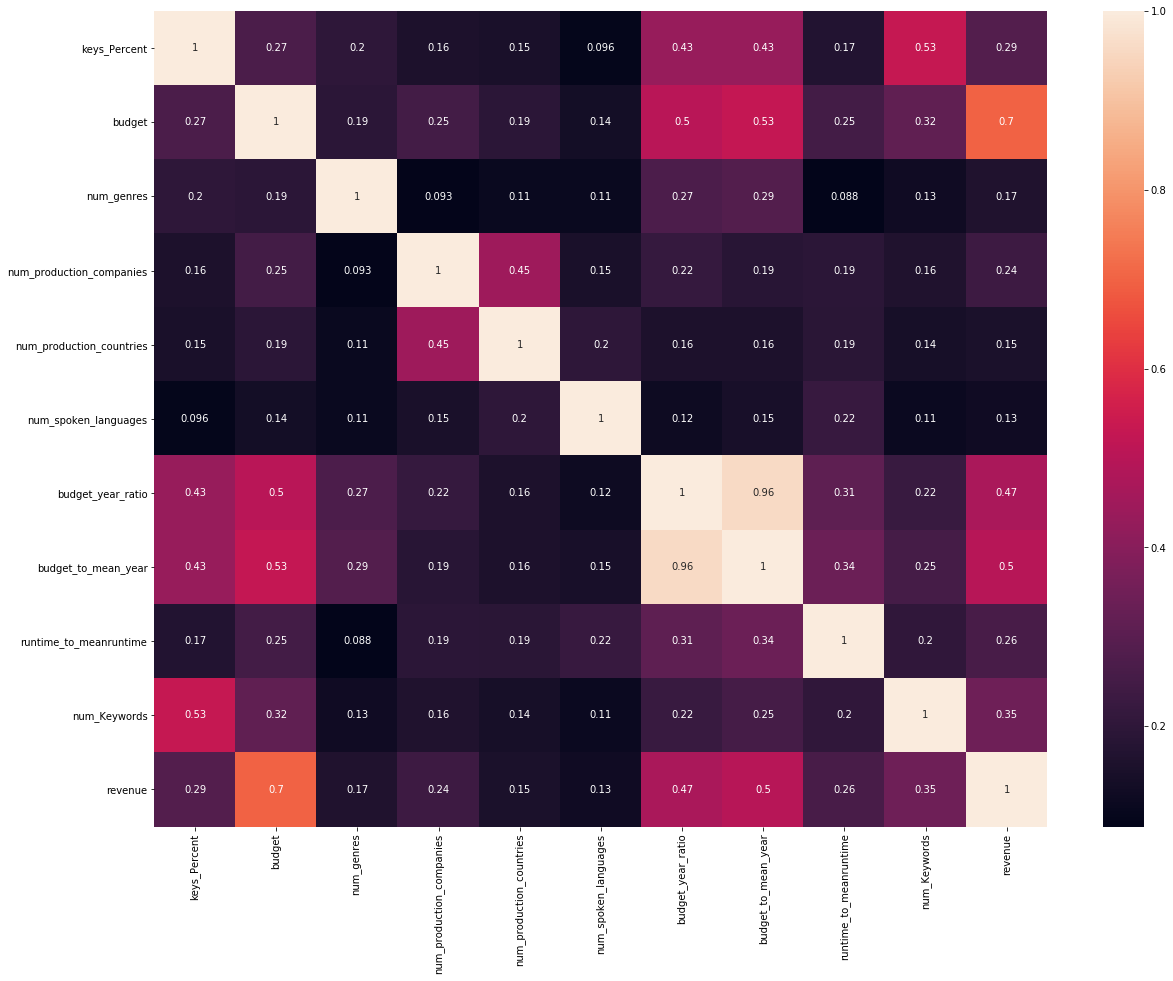

In [6]:
signi_num_var = []  #11
for col in num_variable:
    p, f = pearsonr(tmp['revenue'], tmp[col])
    if p > .1:
        print(col)
        signi_num_var.append(col) 
        
tmp1 = tmp[signi_num_var]
f,ax = plt.subplots(figsize=(20, 15))
sns.heatmap(tmp1.corr(), annot=True)
plt.show()    

we have significant numerical variable. Lets find out significant categorical variable

In [7]:
def anova_stat(df, a, b):
    F, p = stats.f_oneway(df[df[b] == 1][a],
                      df[df[b] == 0][a])
    return p
signi_cat_var = []    #21 features
for col in flag_variable:
    p = anova_stat(tmp, 'revenue', col)
    if p < .05:
        print(col)
        signi_cat_var.append(col)
        
complete_variable_list = signi_num_var + signi_cat_var       
final_data = tmp[complete_variable_list]     #32 total features 

Drama_genre
Comedy_genre
Thriller_genre
Action_genre
Romance_genre
Adventure_genre
Crime_genre
Science Fiction_genre
Horror_genre
Family_genre
Fantasy_genre
Mystery_genre
Animation_genre
War_genre
Documentary_genre
Foreign_genre
TV Movie_genre
has_homepage
eng_language
isMovieReleased
USholidayreleased


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:2923: RuntimeWarning:

invalid value encountered in double_scalars



In [8]:
X = final_data.drop('revenue', axis = 1)
y = final_data['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

# 1.Considering complete dataset 

## 1.1 Baseline Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print('The rmse of prediction of baseline linear regression is :', sqrt(mean_squared_error(y_test, y_pred)))
linear_regression = sqrt(mean_squared_error(y_test, y_pred))

The rmse of prediction of baseline linear regression is : 5.542587567809025


   ##  1.2  RandomForest

In [10]:
rf = RandomForestRegressor(random_state=123)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('The rmse of prediction of baseline randomforest is :', sqrt(mean_squared_error(y_test, y_pred)))
random_forest = sqrt(mean_squared_error(y_test, y_pred))


#Bayesian optimization
def bayesian_optimization(dataset, function, parameters):
    
    
    X_train, y_train, X_test, y_test = dataset
    n_iterations = 30
    gp_params = {"alpha": 1e-4}
    init_points = 12

    BO = BayesianOptimization(function, parameters)
    BO.maximize(n_iter=n_iterations, **gp_params, init_points = init_points)

    return BO.max

## for randomforest
def rfc_optimization(cv_splits):
    def function(n_estimators, max_depth, min_samples_split, max_features, min_samples_leaf): # make changes here to add more parameters 
        
        return cross_val_score(
               RandomForestRegressor(
                   n_estimators=int(max(n_estimators,0)),                                                               
                   max_depth=int(max(max_depth,1)),
                   min_samples_split=int(max(min_samples_split,2)), 
                   max_features = float(max(max_features,0.2)),
                   min_samples_leaf= int(max(min_samples_leaf,50)),
                   #oob_score = True,
                   
                   
                   n_jobs=-1, 
                   random_state=22  
                   ),  
               X=X_train, 
               y=y_train, 
               cv=cv_splits,
               scoring="neg_mean_squared_error",
               n_jobs=-1).mean()

    parameters = {"n_estimators": (100, 1000),
                  "max_depth": (1, 200), #quick note : consider 1 to 200 next time
                  "min_samples_split": (2, 15),
                  "max_features": (0.2, 1),
                  "min_samples_leaf": (50, 100),
                  #"oob_score": True
                  
                 }
    
    return function, parameters

#Train model using optimum parameters
def rftrain(X_train, y_train, X_test, y_test, function, parameters):
    dataset = (X_train, y_train, X_test, y_test)
    cv_splits = 10
    
    best_solution = bayesian_optimization(dataset, function, parameters)      
    params = best_solution["params"]

    model = RandomForestRegressor(
             n_estimators=int(max(params["n_estimators"], 0)),
             max_depth=int(max(params["max_depth"], 1)),
             min_samples_split=int(max(params["min_samples_split"], 2)), 
             max_features = float(max(params["max_features"], 0.2)),
             min_samples_leaf= int(max(params["min_samples_leaf"],50)),
             n_jobs=-1, 
             random_state=23,
             #oob_score = True
             )

    model.fit(X_train, y_train)
    
    return model


rffunc, rfparams = rfc_optimization(10)
rfmodel = rftrain(X_train, y_train, X_test, y_test, rffunc, rfparams)



y_pred = rfmodel.predict(X_test)
print('The rmse of optimize random forest is:', sqrt(mean_squared_error(y_test, y_pred)))
opt_random_forest = sqrt(mean_squared_error(y_test, y_pred))



The rmse of prediction of baseline randomforest is : 5.762243074407854
|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        | -30.54    |  121.9    |  0.2205   |  99.67    |  11.22    |  306.7    |
|  2        | -30.07    |  9.397    |  0.9072   |  89.0     |  3.697    |  867.6    |
|  3        | -29.76    |  70.5     |  0.5706   |  50.59    |  9.97     |  409.3    |
|  4        | -29.97    |  39.35    |  0.7105   |  74.04    |  5.263    |  815.8    |
|  5        | -30.1     |  116.3    |  0.9085   |  95.26    |  8.648    |  742.8    |
|  6        | -29.84    |  136.0    |  0.8314   |  56.26    |  12.57    |  614.9    |
|  7        | -29.99    |  196.4    |  0.7786   |  76.53    |  13.86    |  606.1    |
|  8        | -30.1     |  171.2    |  0.5447   |  97.46    |  6.903    |  328.1    |
|  9        | -29.93    |  195.4    |  0.7719   |  69.11    |  7.105 

   ##  1.3  XGBoost

[15:57:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The rmse of XGBoost Baseline is : 5.336937873384235


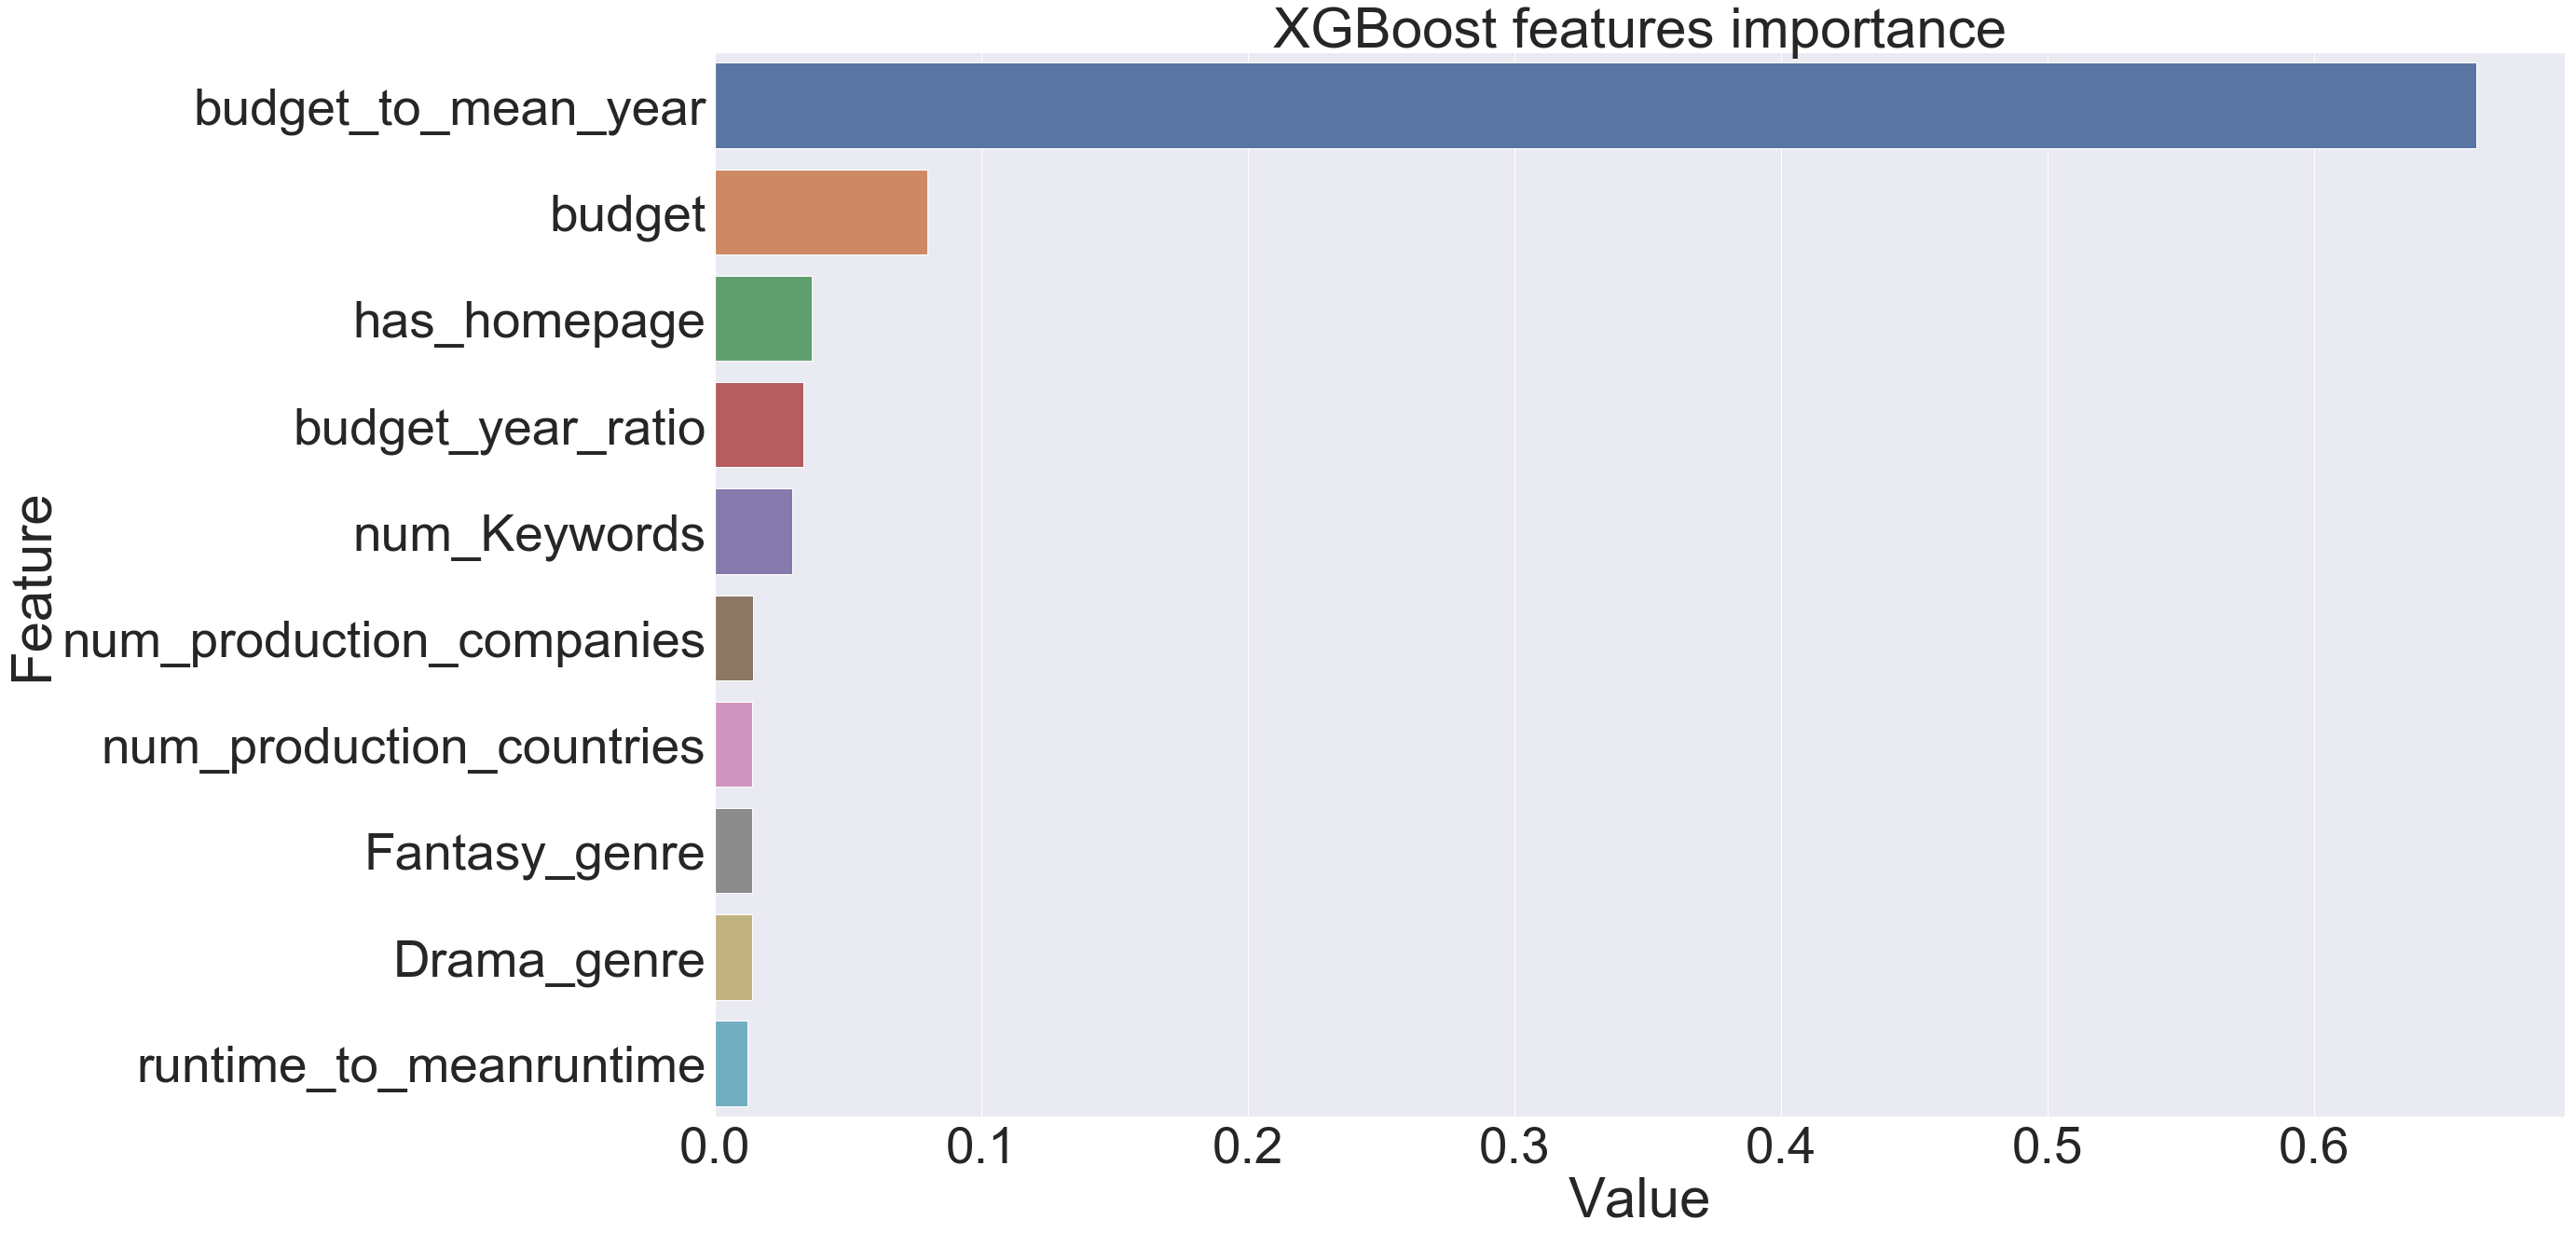

|   iter    |  target   |    eta    |   gamma   | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------------------
|  1        | -30.03    |  0.199    |  0.9081   |  5.123    |  6.503    |  128.0    |
|  2        | -29.89    |  0.1811   |  1.209    |  5.16     |  8.222    |  133.9    |
|  3        | -29.44    |  0.1294   |  1.801    |  3.042    |  8.256    |  52.15    |
|  4        | -29.43    |  0.1962   |  0.4739   |  2.441    |  8.737    |  112.4    |
|  5        | -30.44    |  0.1879   |  0.8661   |  6.562    |  4.1      |  142.4    |
|  6        | -30.0     |  0.08431  |  1.093    |  5.469    |  4.666    |  107.5    |
|  7        | -29.36    |  0.08204  |  1.754    |  2.513    |  9.428    |  102.3    |
|  8        | -30.77    |  0.1199   |  1.829    |  7.728    |  3.355    |  59.23    |
|  9        | -29.44    |  0.1093   |  0.3648   |  2.098    |  8.525    |  111.7    |
|  10       | -29.55    |  0.1337   |  1.268    |  4.2

In [11]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('The rmse of XGBoost Baseline is :', sqrt(mean_squared_error(y_test, y_pred)))
xgboost = sqrt(mean_squared_error(y_test, y_pred))
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), 
                               columns=['Value','Feature'])
plt.figure(figsize=(40, 20))
sns.set(font_scale = 5)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:10])
plt.title('XGBoost features importance')
plt.tight_layout()
plt.savefig('feaimp_xgb.png')
plt.show()
del feature_imp


eval_set = [(X_test, y_test)]
def xgb_optimization(cv_splits, eval_set):
    def function(eta, gamma, max_depth,n_estimators,min_child_weight):  
            return cross_val_score(
                   xgb.XGBRegressor(
                       n_estimators=int(max(n_estimators,50)),
                       objective="reg:linear",
                       learning_rate=max(eta, 0),
                       gamma=max(gamma, 0),
                       max_depth=max(int(max_depth), 1),   
                       min_child_weight=max(min_child_weight, 1),
                       #subsample = max(subsample, 0),
                       #colsample_bytree = max(colsample_bytree, 0),
                       #colsample_bylevel = max(colsample_bylevel, 0),

                       seed=42,
                       nthread=-1
                       ),  
                   X=X_train, 
                   y=y_train, 
                   cv=cv_splits,
                   scoring='neg_mean_squared_error',
                   fit_params={
                        "early_stopping_rounds": 200, 
                        "eval_metric": "rmse", 
                        "eval_set": eval_set},
                   n_jobs=-1).mean()

    parameters = {"eta": (0.07, 0.2),
                  "gamma": (0,2),
                  "max_depth": (1, 10),
                 "min_child_weight": (1, 10),
                 #"subsample": (0,1),
                 #"colsample_bytree": (0,1),
                  "n_estimators": (50,150), 
                  #"colsample_bylevel": (0,1)
                  
                 }
    
    return function, parameters

#Train model using optimum parameters
def xgbtrain(X_train, y_train, X_test, y_test, function, parameters):
    dataset = (X_train, y_train, X_test, y_test)
    cv_splits = 10
    
    best_solution = bayesian_optimization(dataset, function, parameters)      
    params = best_solution["params"]

    model = XGBRegressor(
             n_estimators=int(params["n_estimators"]),
             objective="reg:linear",
             learning_rate= params["eta"],
             gamma=int(params["gamma"]),
             max_depth=int(params["max_depth"]),
             min_child_weight=int(params["min_child_weight"]),
             #subsample=int(params["subsample"]),
             #colsample_bytree=int(params["colsample_bytree"]),
             #colsample_bylevel = int(params["colsample_bylevel"]),
             nthread=-1, 
             seed=42 
             )

    model.fit(X_train, y_train)
    
    return model


xgbfunction, xgbparameters = xgb_optimization(10, eval_set)
xgbmodel =xgbtrain(X_train, y_train, X_test, y_test, xgbfunction, xgbparameters)


y_pred = xgbmodel.predict(X_test)
print('The rmse of optimize XGBoost is :', sqrt(mean_squared_error(y_test, y_pred)))
opt_xgboost = sqrt(mean_squared_error(y_test, y_pred))




## 1.4  LightGBM

In [12]:
train_set = lgb.Dataset(X_train, label=y_train)
valid_set = lgb.Dataset(X_test, label=y_test)
params = {
        "objective" : "regression", 
        "metric" : "rmse", 
        "num_leaves" : 100, 
        "learning_rate" : 0.03, 
        "bagging_fraction" : 0.9,
        "bagging_seed" : 0, 
        "num_threads" : 4,
        "colsample_bytree" : 0.5,
        'min_data_in_leaf':1900, 
        'min_split_gain':0.00011,
        'lambda_l2':9
}

print("And we have started traning our model")
model1 = lgb.train(  params, 
                    train_set = train_set,
                    num_boost_round=9400,
                    early_stopping_rounds=200,
                    verbose_eval=100, 
                    valid_sets=[train_set,valid_set]
                  )
  
    
y_pred=model1.predict(X_test, num_iteration=model1.best_iteration)    
print('The rmse of Baseline Lightgbm is :', sqrt(mean_squared_error(y_test, y_pred)))
lightgbm_base = sqrt(mean_squared_error(y_test, y_pred))



And we have started traning our model
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 6.48987	valid_1's rmse: 6.43478
[200]	training's rmse: 6.40739	valid_1's rmse: 6.34674
[300]	training's rmse: 6.39956	valid_1's rmse: 6.33776
[400]	training's rmse: 6.39788	valid_1's rmse: 6.33716
[500]	training's rmse: 6.39666	valid_1's rmse: 6.33739
[600]	training's rmse: 6.39585	valid_1's rmse: 6.33736
Early stopping, best iteration is:
[476]	training's rmse: 6.39692	valid_1's rmse: 6.33693
The rmse of Baseline Lightgbm is : 6.336933589050957


## 1.6 LightGBM with Bayesian Optimization 

In [13]:
def bayesion_opt_lgbm(X, y, init_iter=12, n_iters=30, random_state=11, seed = 101, num_iterations = 200):
    
    
    dtrain = lgb.Dataset(data=X, label=y)
      
      # Objective Function
    def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight, n_estimators, learning_rate, subsample, colsample_bytree):
        
        params = {'application':'regression','num_iterations': num_iterations, 
                         'early_stopping_round':50,
                        'metric':'l2'} # Default parameters 
       
                
        params["n_estimators"] = int(max(n_estimators, 10)) 
        params["learning_rate"] = float(max(learning_rate, 0 ))
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['subsample'] = max(subsample, 0)
        params['colsample_bytree'] = max(colsample_bytree, 0)
        
       
             
            
            
        cv_results = lgb.cv(params, dtrain, nfold=5, seed=seed, stratified=False,
                                  verbose_eval =None, metrics=['l2'])
              # print(cv_results)
        return -np.min(cv_results['l2-mean'])
    
    
      # Domain space-- Range of hyperparameters 
    pds = {     'num_leaves': (10, 100),
                'feature_fraction': (0.1, 0.9),
                'bagging_fraction': (0.8, 1),
                'max_depth': (1, 2000),
                'min_split_gain': (0.001, 0.1),
                'min_child_weight': (10, 25),
                'n_estimators' : (10,10000),
                "learning_rate": (0.001, 0.4),
                "subsample": (0, 1),
                "colsample_bytree" : (0, 1)
                
                }

      # Surrogate model
    optimizer = BayesianOptimization(hyp_lgbm, pds, random_state=random_state)

      # Optimize
    optimizer.maximize(init_points=init_iter, n_iter=n_iters)
    return optimizer.max

opt_params = bayesion_opt_lgbm(X, y, init_iter=12, n_iters=30, random_state=77, seed = 101, num_iterations = 200)
opt_params


|   iter    |  target   | baggin... | colsam... | featur... | learni... | max_depth | min_ch... | min_sp... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  1        | -29.64    |  0.9838   |  0.6422   |  0.703    |  0.05659  |  175.6    |  21.82    |  0.03329  |  5.415e+0 |  31.62    |  0.5454   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  2        | -29.52    |  0.8801   |  0.7152   |  0.7693   |  0.2358   |  593.0    |  14.22    |  0.07085  |  4.232e+0 |  15.16    |  0.747    |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  3        | -30.3     |  0.8905   |  0.1758   |  0.1395   |  0.1177   |  134.5    |  21.27    |  0.007313 |  4.325e+0 |  42.78    |  0.152    |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  4        | -31.83    |  0.9093   |  0.4433   |  0.1288   |  0.3293   |  547.3    |  12.53    |  0.06479  |  1.084e+0 |  41.79    |  0.3857   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  5        | -29.64    |  0.8891   |  0.9771   |  0.6835   |  0.1256   |  1.79e+03 |  21.75    |  0.02694  |  3.102e+0 |  21.65    |  0.4222   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  6        | -30.76    |  0.988    |  0.367    |  0.4478   |  0.3669   |  1.895e+0 |  13.82    |  0.07126  |  509.3    |  22.13    |  0.5065   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  7        | -30.17    |  0.9178   |  0.3269   |  0.2159   |  0.1038   |  1.715e+0 |  20.26    |  0.09986  |  3.201e+0 |  50.81    |  0.8676   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  8        | -29.5     |  0.9277   |  0.3319   |  0.5336   |  0.04582  |  1.633e+0 |  13.31    |  0.05198  |  5.266e+0 |  34.94    |  0.9044   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  9        | -29.58    |  0.8841   |  0.949    |  0.7292   |  0.1931   |  24.83    |  10.9     |  0.08275  |  4.052e+0 |  14.78    |  0.2596   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  10       | -30.62    |  0.8562   |  0.9433   |  0.8149   |  0.08171  |  201.6    |  18.6     |  0.07479  |  6.012e+0 |  91.83    |  0.9386   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  11       | -30.42    |  0.9123   |  0.8908   |  0.35     |  0.3087   |  428.1    |  14.33    |  0.02807  |  2.493e+0 |  11.3     |  0.6091   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  12       | -30.45    |  0.9724   |  0.2591   |  0.7935   |  0.1712   |  321.6    |  10.85    |  0.04286  |  7.363e+0 |  52.93    |  0.7007   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  13       | -29.82    |  0.8      |  1.0      |  0.9      |  0.4      |  2e+03    |  25.0     |  0.001    |  2.737e+0 |  10.0     |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  14       | -29.57    |  0.8      |  1.0      |  0.9      |  0.2851   |  420.5    |  10.0     |  0.1      |  3.722e+0 |  10.0     |  0.8473   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  15       | -54.54    |  0.9436   |  1.0      |  0.9      |  0.001    |  1.104e+0 |  11.06    |  0.001    |  4.828e+0 |  16.06    |  1.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  16       | -29.55    |  0.8495   |  0.8072   |  0.7555   |  0.2201   |  381.4    |  12.66    |  0.08315  |  4.043e+0 |  15.31    |  0.6088   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  17       | -29.59    |  0.8054   |  0.8755   |  0.7101   |  0.2064   |  220.0    |  11.16    |  0.03846  |  3.879e+0 |  14.59    |  0.5463   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  18       | -29.51    |  0.8184   |  0.7983   |  0.7753   |  0.3097   |  591.6    |  12.68    |  0.01832  |  3.985e+0 |  11.85    |  0.8668   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  19       | -62.83    |  1.0      |  0.0      |  0.1      |  0.001    |  436.3    |  25.0     |  0.1      |  3.879e+0 |  100.0    |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  20       | -29.76    |  0.8492   |  0.2215   |  0.7622   |  0.05406  |  1.622e+0 |  20.02    |  0.05359  |  5.263e+0 |  42.26    |  0.309    |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  21       | -30.3     |  0.963    |  0.4702   |  0.5951   |  0.2553   |  1.64e+03 |  15.88    |  0.02428  |  5.246e+0 |  37.12    |  0.8984   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  22       | -29.86    |  0.9794   |  0.721    |  0.2024   |  0.09296  |  1.621e+0 |  16.17    |  0.05006  |  5.266e+0 |  16.76    |  0.5379   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  23       | -29.74    |  0.896    |  0.8308   |  0.5781   |  0.1208   |  1.773e+0 |  21.4     |  0.04339  |  3.124e+0 |  28.17    |  0.5213   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  24       | -30.16    |  0.8      |  1.0      |  0.9      |  0.4      |  1.637e+0 |  25.0     |  0.1      |  5.29e+03 |  31.76    |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  25       | -30.78    |  0.8534   |  0.4376   |  0.5507   |  0.3586   |  1.804e+0 |  13.02    |  0.06722  |  3.125e+0 |  31.77    |  0.6526   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  26       | -30.09    |  0.9016   |  0.296    |  0.341    |  0.1015   |  1.763e+0 |  25.0     |  0.03565  |  3.094e+0 |  36.7     |  0.5004   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  27       | -29.59    |  0.826    |  0.9408   |  0.8612   |  0.2765   |  372.9    |  10.56    |  0.0924   |  4.07e+03 |  10.0     |  0.7052   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  28       | -30.82    |  1.0      |  0.0      |  0.1      |  0.3948   |  352.3    |  25.0     |  0.001    |  4.048e+0 |  11.7     |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  29       | -29.62    |  0.8139   |  0.9494   |  0.8999   |  0.377    |  611.7    |  10.73    |  0.02074  |  4.006e+0 |  10.0     |  0.9923   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  30       | -29.33    |  0.8      |  1.0      |  0.9      |  0.02257  |  407.5    |  10.0     |  0.1      |  4.065e+0 |  10.0     |  1.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  31       | -29.59    |  0.8      |  0.7721   |  0.6459   |  0.3148   |  623.5    |  13.57    |  0.0353   |  3.972e+0 |  10.0     |  0.9788   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  32       | -30.27    |  0.9574   |  0.6915   |  0.8399   |  0.1768   |  406.2    |  12.56    |  0.08133  |  4.067e+0 |  40.95    |  0.04957  |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  33       | -62.84    |  0.8      |  0.0      |  0.1      |  0.001    |  611.5    |  25.0     |  0.001    |  3.988e+0 |  40.12    |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  34       | -30.31    |  0.8509   |  0.9473   |  0.7511   |  0.3589   |  1.625e+0 |  24.9     |  0.09808  |  5.267e+0 |  39.85    |  0.7321   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  35       | -29.96    |  0.8911   |  0.8355   |  0.6066   |  0.1332   |  1.782e+0 |  21.46    |  0.03616  |  3.111e+0 |  25.98    |  0.4791   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  36       | -31.21    |  0.8132   |  0.6696   |  0.1479   |  0.3112   |  1.637e+0 |  15.65    |  0.04171  |  5.273e+0 |  38.08    |  0.8892   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  37       | -29.86    |  0.8937   |  0.2975   |  0.8209   |  0.1847   |  1.633e+0 |  16.65    |  0.02177  |  5.268e+0 |  33.51    |  0.0886   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  38       | -30.1     |  0.841    |  0.5876   |  0.8792   |  0.3281   |  1.796e+0 |  21.49    |  0.03637  |  3.111e+0 |  27.49    |  0.7856   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  39       | -29.35    |  0.8243   |  0.5213   |  0.432    |  0.01904  |  1.626e+0 |  18.93    |  0.03166  |  5.269e+0 |  25.06    |  0.991    |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  40       | -29.83    |  0.9358   |  0.6929   |  0.7775   |  0.1106   |  1.616e+0 |  15.66    |  0.09774  |  5.26e+03 |  33.83    |  0.2157   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  41       | -29.77    |  0.9022   |  0.5861   |  0.6371   |  0.2947   |  418.8    |  13.58    |  0.09814  |  3.725e+0 |  15.72    |  0.7983   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  42       | -30.13    |  0.8225   |  0.3343   |  0.5029   |  0.2805   |  378.1    |  17.12    |  0.04251  |  4.061e+0 |  15.17    |  0.6063   |


{'target': -29.331421719467887,
 'params': {'bagging_fraction': 0.8,
  'colsample_bytree': 1.0,
  'feature_fraction': 0.9,
  'learning_rate': 0.022565510994799875,
  'max_depth': 407.5489220510617,
  'min_child_weight': 10.0,
  'min_split_gain': 0.1,
  'n_estimators': 4064.561297237613,
  'num_leaves': 10.0,
  'subsample': 1.0}}

In [14]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict

params = {'bagging_fraction': 0.9,
  'colsample_bytree': 0.7,
  'feature_fraction': 0.6,
  'learning_rate': 0.04,
  'max_depth': 594,
  'min_child_weight': 15,
  'min_split_gain': 0.05,
  'n_estimators': 4232,
  'num_leaves': 10,
  'subsample': 0.7}


print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=lgb_eval)



print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', sqrt(mean_squared_error(y_test, y_pred)))
opt_lightgbm = sqrt(mean_squared_error(y_test, y_pred))



Starting training...


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Starting predicting...
The rmse of prediction is: 5.808855466008516


# 2. Considering observation where revenue != 0

In [15]:
newdf = final_data[final_data['revenue'] != 0]
newdf_V2 = final_data[final_data['revenue'] == 0] #we are going to replace these zeros with prediction
X = newdf.drop('revenue', axis = 1)
y = newdf['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)
## we are going to use this at the end. 
final_check_X_test = X_test 
final_check_y_test = y_test

## 2.1 Random Forest

In [16]:
rf = RandomForestRegressor(n_estimators=50, random_state=123)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('The rmse of Random Forest Baseline is :', sqrt(mean_squared_error(y_test, y_pred)))

#Bayesian optimization
def bayesian_optimization(dataset, function, parameters):
    
    
    X_train, y_train, X_test, y_test = dataset
    n_iterations = 30
    gp_params = {"alpha": 1e-4}
    init_points = 12

    BO = BayesianOptimization(function, parameters)
    BO.maximize(n_iter=n_iterations, **gp_params, init_points = init_points)

    return BO.max

## for randomforest
def rfc_optimization(cv_splits):
    def function(n_estimators, max_depth, min_samples_split, max_features, min_samples_leaf): # make changes here to add more parameters 
        
        return cross_val_score(
               RandomForestRegressor(
                   n_estimators=int(max(n_estimators,0)),                                                               
                   max_depth=int(max(max_depth,1)),
                   min_samples_split=int(max(min_samples_split,2)), 
                   max_features = float(max(max_features,0.2)),
                   min_samples_leaf= int(max(min_samples_leaf,50)),
                   #oob_score = True,
                   
                   
                   n_jobs=-1, 
                   random_state=22  
                   ),  
               X=X_train, 
               y=y_train, 
               cv=cv_splits,
               scoring="neg_mean_squared_error",
               n_jobs=-1).mean()

    parameters = {"n_estimators": (100, 1000),
                  "max_depth": (1, 200), #quick note : consider 1 to 200 next time
                  "min_samples_split": (2, 15),
                  "max_features": (0.2, 1),
                  "min_samples_leaf": (50, 100),
                  #"oob_score": True
                  
                 }
    
    return function, parameters

#Train model using optimum parameters
def rftrain(X_train, y_train, X_test, y_test, function, parameters):
    dataset = (X_train, y_train, X_test, y_test)
    cv_splits = 10
    
    best_solution = bayesian_optimization(dataset, function, parameters)      
    params = best_solution["params"]

    model = RandomForestRegressor(
             n_estimators=int(max(params["n_estimators"], 0)),
             max_depth=int(max(params["max_depth"], 1)),
             min_samples_split=int(max(params["min_samples_split"], 2)), 
             max_features = float(max(params["max_features"], 0.2)),
             min_samples_leaf= int(max(params["min_samples_leaf"],50)),
             n_jobs=-1, 
             random_state=23,
             #oob_score = True
             )

    model.fit(X_train, y_train)
    
    return model


rffunc, rfparams = rfc_optimization(10)
rfmodel = rftrain(X_train, y_train, X_test, y_test, rffunc, rfparams)



y_pred = rfmodel.predict(X_test)
print('The rmse of bayesian optimize random forest is :', sqrt(mean_squared_error(y_test, y_pred)))

The rmse of Random Forest Baseline is : 1.5939341669069251
|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        | -2.922    |  132.4    |  0.3897   |  84.12    |  4.686    |  654.0    |
|  2        | -2.912    |  188.2    |  0.9579   |  71.7     |  12.97    |  573.3    |
|  3        | -2.905    |  167.9    |  0.6554   |  68.2     |  9.864    |  433.5    |
|  4        | -2.891    |  48.29    |  0.4603   |  59.99    |  7.907    |  183.4    |
|  5        | -2.92     |  108.0    |  0.5498   |  88.46    |  7.399    |  372.1    |
|  6        | -2.94     |  168.1    |  0.3492   |  94.69    |  11.52    |  362.1    |
|  7        | -2.915    |  45.59    |  0.2959   |  70.62    |  12.21    |  278.2    |
|  8        | -2.903    |  97.76    |  0.9074   |  58.79    |  4.378    |  953.2    |
|  9        | -2.938    |  152.3    |  0.2867   |  82.45    |  7.673    |  353.8 

## 2.2 XGBoost

In [17]:
xgbmodel_base = xgb.XGBRegressor()
xgbmodel_base.fit(X_train, y_train)
y_pred = xgbmodel_base.predict(X_test)
print('The rmse of XGBoost Baseline:', sqrt(mean_squared_error(y_test, y_pred)))

eval_set = [(X_test, y_test)]
def xgb_optimization(cv_splits, eval_set):
    def function(eta, gamma, max_depth,n_estimators,min_child_weight):  
            return cross_val_score(
                   xgb.XGBRegressor(
                       n_estimators=int(max(n_estimators,50)),
                       objective="reg:linear",
                       learning_rate=max(eta, 0),
                       gamma=max(gamma, 0),
                       max_depth=max(int(max_depth), 1),   
                       min_child_weight=max(min_child_weight, 1),
                       #subsample = max(subsample, 0),
                       #colsample_bytree = max(colsample_bytree, 0),
                       #colsample_bylevel = max(colsample_bylevel, 0),

                       seed=42,
                       nthread=-1
                       ),  
                   X=X_train, 
                   y=y_train, 
                   cv=cv_splits,
                   scoring='neg_mean_squared_error',
                   fit_params={
                        "early_stopping_rounds": 200, 
                        "eval_metric": "rmse", 
                        "eval_set": eval_set},
                   n_jobs=-1).mean()

    parameters = {"eta": (0.07, 0.2),
                  "gamma": (0,2),
                  "max_depth": (1, 10),
                 "min_child_weight": (1, 10),
                 #"subsample": (0,1),
                 #"colsample_bytree": (0,1),
                  "n_estimators": (50,150), 
                  #"colsample_bylevel": (0,1)
                  
                 }
    
    return function, parameters

#Train model using optimum parameters
def xgbtrain(X_train, y_train, X_test, y_test, function, parameters):
    dataset = (X_train, y_train, X_test, y_test)
    cv_splits = 10
    
    best_solution = bayesian_optimization(dataset, function, parameters)      
    params = best_solution["params"]

    model = XGBRegressor(
             n_estimators=int(params["n_estimators"]),
             objective="reg:linear",
             learning_rate= params["eta"],
             gamma=int(params["gamma"]),
             max_depth=int(params["max_depth"]),
             min_child_weight=int(params["min_child_weight"]),
             #subsample=int(params["subsample"]),
             #colsample_bytree=int(params["colsample_bytree"]),
             #colsample_bylevel = int(params["colsample_bylevel"]),
             nthread=-1, 
             seed=42 
             )

    model.fit(X_train, y_train)
    
    return model


xgbfunction, xgbparameters = xgb_optimization(10, eval_set)
xgbmodel =xgbtrain(X_train, y_train, X_test, y_test, xgbfunction, xgbparameters)


y_pred = xgbmodel.predict(X_test)
print('The rmse of optimize XGBoost is :', sqrt(mean_squared_error(y_test, y_pred)))
opt_xgboost = sqrt(mean_squared_error(y_test, y_pred))




[16:28:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The rmse of XGBoost Baseline: 1.52591744458347
|   iter    |  target   |    eta    |   gamma   | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------------------
|  1        | -2.821    |  0.08469  |  1.526    |  8.237    |  7.526    |  72.78    |
|  2        | -2.888    |  0.1018   |  1.923    |  8.778    |  2.956    |  53.43    |
|  3        | -2.842    |  0.1459   |  0.7409   |  8.22     |  4.222    |  65.08    |
|  4        | -2.931    |  0.1908   |  0.8197   |  5.107    |  1.154    |  85.86    |
|  5        | -2.968    |  0.1934   |  1.766    |  6.301    |  1.444    |  126.8    |
|  6        | -2.741    |  0.1377   |  0.7699   |  4.499    |  7.645    |  134.1    |
|  7        | -2.881    |  0.1362   |  0.05693  |  8.156    |  4.934    |  144.1    |
|  8        | -

## 2.3 Lightgbm

In [18]:
train_set = lgb.Dataset(X_train, label=y_train)
valid_set = lgb.Dataset(X_test, label=y_test)
params = {
        "objective" : "regression", 
        "metric" : "rmse", 
        "num_leaves" : 100, 
        "learning_rate" : 0.03, 
        "bagging_fraction" : 0.9,
        "bagging_seed" : 0, 
        "num_threads" : 4,
        "colsample_bytree" : 0.5,
        'min_data_in_leaf':1900, 
        'min_split_gain':0.00011,
        'lambda_l2':9
}

model = lgb.train(  params, 
                    train_set = train_set,
                    num_boost_round=9400,
                    early_stopping_rounds=200,
                    verbose_eval=100, 
                    valid_sets=[train_set,valid_set]
                  )


y_pred=model.predict(X_test, num_iteration=model.best_iteration)
print('The rmse of Baseline lightgbm is :', sqrt(mean_squared_error(y_test, y_pred)))

def bayesion_opt_lgbm(X, y, init_iter=12, n_iters=30, random_state=11, seed = 101, num_iterations = 200):
    
    
    dtrain = lgb.Dataset(data=X, label=y)
      
      # Objective Function
    def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight, n_estimators, learning_rate, subsample, colsample_bytree):
        
        params = {'application':'regression','num_iterations': num_iterations, 
                         'early_stopping_round':50,
                        'metric':'l2'} # Default parameters 
       
                
        params["n_estimators"] = int(max(n_estimators, 10)) 
        params["learning_rate"] = float(max(learning_rate, 0 ))
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['subsample'] = max(subsample, 0)
        params['colsample_bytree'] = max(colsample_bytree, 0)
        
       
             
            
            
        cv_results = lgb.cv(params, dtrain, nfold=5, seed=seed, stratified=False,
                                  verbose_eval =None, metrics=['l2'])
              # print(cv_results)
        return -np.min(cv_results['l2-mean'])
    
    
      # Domain space-- Range of hyperparameters 
    pds = {     'num_leaves': (10, 100),
                'feature_fraction': (0.1, 0.9),
                'bagging_fraction': (0.8, 1),
                'max_depth': (1, 2000),
                'min_split_gain': (0.001, 0.1),
                'min_child_weight': (10, 25),
                'n_estimators' : (10,10000),
                "learning_rate": (0.001, 0.4),
                "subsample": (0, 1),
                "colsample_bytree" : (0, 1)
                
                }

      # Surrogate model
    optimizer = BayesianOptimization(hyp_lgbm, pds, random_state=random_state)

      # Optimize
    optimizer.maximize(init_points=init_iter, n_iter=n_iters)
    return optimizer.max

opt_params = bayesion_opt_lgbm(X, y, init_iter=12, n_iters=30, random_state=77, seed = 101, num_iterations = 200)

opt_params


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 17.5089	valid_1's rmse: 17.4088
[200]	training's rmse: 17.5089	valid_1's rmse: 17.4088
Early stopping, best iteration is:
[1]	training's rmse: 17.5089	valid_1's rmse: 17.4088
The rmse of Baseline lightgbm is : 2.1158139613700784
|   iter    |  target   | baggin... | colsam... | featur... | learni... | max_depth | min_ch... | min_sp... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  1        | -2.64     |  0.9838   |  0.6422   |  0.703    |  0.05659  |  175.6    |  21.82    |  0.03329  |  5.415e+0 |  31.62    |  0.5454   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  2        | -2.682    |  0.8801   |  0.7152   |  0.7693   |  0.2358   |  593.0    |  14.22    |  0.07085  |  4.232e+0 |  15.16    |  0.747    |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  3        | -2.817    |  0.8905   |  0.1758   |  0.1395   |  0.1177   |  134.5    |  21.27    |  0.007313 |  4.325e+0 |  42.78    |  0.152    |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  4        | -2.97     |  0.9093   |  0.4433   |  0.1288   |  0.3293   |  547.3    |  12.53    |  0.06479  |  1.084e+0 |  41.79    |  0.3857   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  5        | -2.654    |  0.8891   |  0.9771   |  0.6835   |  0.1256   |  1.79e+03 |  21.75    |  0.02694  |  3.102e+0 |  21.65    |  0.4222   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  6        | -2.703    |  0.988    |  0.367    |  0.4478   |  0.3669   |  1.895e+0 |  13.82    |  0.07126  |  509.3    |  22.13    |  0.5065   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  7        | -2.741    |  0.9178   |  0.3269   |  0.2159   |  0.1038   |  1.715e+0 |  20.26    |  0.09986  |  3.201e+0 |  50.81    |  0.8676   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  8        | -2.634    |  0.9277   |  0.3319   |  0.5336   |  0.04582  |  1.633e+0 |  13.31    |  0.05198  |  5.266e+0 |  34.94    |  0.9044   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  9        | -2.647    |  0.8841   |  0.949    |  0.7292   |  0.1931   |  24.83    |  10.9     |  0.08275  |  4.052e+0 |  14.78    |  0.2596   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  10       | -2.705    |  0.8562   |  0.9433   |  0.8149   |  0.08171  |  201.6    |  18.6     |  0.07479  |  6.012e+0 |  91.83    |  0.9386   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  11       | -2.681    |  0.9123   |  0.8908   |  0.35     |  0.3087   |  428.1    |  14.33    |  0.02807  |  2.493e+0 |  11.3     |  0.6091   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  12       | -2.705    |  0.9724   |  0.2591   |  0.7935   |  0.1712   |  321.6    |  10.85    |  0.04286  |  7.363e+0 |  52.93    |  0.7007   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  13       | -2.726    |  1.0      |  1.0      |  0.9      |  0.4      |  2e+03    |  10.0     |  0.1      |  1e+04    |  10.0     |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  14       | -4.718    |  0.8      |  0.0      |  0.1      |  0.001    |  1.0      |  25.0     |  0.001    |  1e+04    |  100.0    |  1.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  15       | -2.749    |  1.0      |  1.0      |  0.9      |  0.388    |  2e+03    |  10.0     |  0.1      |  7.65e+03 |  10.0     |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  16       | -3.218    |  0.9069   |  1.0      |  0.9      |  0.003827 |  2e+03    |  10.0     |  0.1      |  1.782e+0 |  100.0    |  0.6313   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  17       | -4.439    |  0.8      |  1.0      |  0.9      |  0.001    |  1.0      |  25.0     |  0.001    |  10.0     |  10.0     |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  18       | -2.711    |  1.0      |  1.0      |  0.9      |  0.4      |  2e+03    |  25.0     |  0.1      |  6.412e+0 |  10.0     |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  19       | -4.649    |  1.0      |  0.0      |  0.1      |  0.001    |  2e+03    |  25.0     |  0.1      |  8.876e+0 |  100.0    |  1.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  20       | -2.764    |  0.8      |  0.0      |  0.1      |  0.4      |  1.165e+0 |  10.0     |  0.001    |  6.884e+0 |  10.0     |  1.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  21       | -2.692    |  0.8      |  1.0      |  0.9      |  0.4      |  2e+03    |  25.0     |  0.001    |  4.341e+0 |  10.0     |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  22       | -2.561    |  0.991    |  0.0      |  0.9      |  0.4      |  1.0      |  25.0     |  0.001    |  3.129e+0 |  100.0    |  0.1358   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  23       | -2.561    |  1.0      |  1.0      |  0.9      |  0.4      |  1.0      |  25.0     |  0.1      |  1.831e+0 |  100.0    |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  24       | -4.649    |  0.8      |  1.0      |  0.1      |  0.001    |  2e+03    |  25.0     |  0.001    |  10.0     |  100.0    |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  25       | -2.711    |  1.0      |  0.0      |  0.9      |  0.4      |  1.45e+03 |  25.0     |  0.1      |  1.05e+03 |  10.0     |  1.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  26       | -2.561    |  0.8      |  1.0      |  0.9      |  0.4      |  1.0      |  25.0     |  0.1      |  8.289e+0 |  10.0     |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  27       | -2.978    |  1.0      |  0.0      |  0.1      |  0.4      |  1.036e+0 |  25.0     |  0.1      |  5.848e+0 |  100.0    |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  28       | -2.711    |  1.0      |  1.0      |  0.9      |  0.4      |  907.9    |  25.0     |  0.1      |  7.976e+0 |  10.0     |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  29       | -2.692    |  0.8      |  1.0      |  0.9      |  0.4      |  724.7    |  25.0     |  0.001    |  3.357e+0 |  10.0     |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  30       | -2.826    |  1.0      |  1.0      |  0.9      |  0.4      |  1.209e+0 |  25.0     |  0.1      |  4.699e+0 |  100.0    |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  31       | -2.764    |  1.0      |  0.0      |  0.1      |  0.4      |  2e+03    |  10.0     |  0.001    |  986.6    |  10.0     |  1.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  32       | -2.826    |  1.0      |  0.0      |  0.9      |  0.4      |  1.242e+0 |  25.0     |  0.1      |  2.342e+0 |  100.0    |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  33       | -4.439    |  1.0      |  1.0      |  0.9      |  0.001    |  1.0      |  25.0     |  0.1      |  6.732e+0 |  10.0     |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  34       | -3.006    |  1.0      |  0.0      |  0.1      |  0.4      |  2e+03    |  10.0     |  0.001    |  7.051e+0 |  100.0    |  1.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  35       | -4.154    |  0.8      |  1.0      |  0.9      |  0.001    |  2e+03    |  10.0     |  0.001    |  5.706e+0 |  100.0    |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  36       | -4.154    |  1.0      |  0.0      |  0.9      |  0.001    |  586.3    |  10.0     |  0.001    |  8.792e+0 |  100.0    |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  37       | -2.726    |  1.0      |  1.0      |  0.9      |  0.4      |  762.5    |  10.0     |  0.1      |  1.77e+03 |  10.0     |  1.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  38       | -4.718    |  1.0      |  0.0      |  0.1      |  0.001    |  1.0      |  10.0     |  0.001    |  7.797e+0 |  100.0    |  1.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  39       | -4.188    |  0.9787   |  0.4116   |  0.5221   |  0.001    |  246.9    |  17.99    |  0.01136  |  3.569e+0 |  66.58    |  0.6482   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  40       | -2.83     |  0.8781   |  0.3814   |  0.766    |  0.4      |  171.4    |  21.86    |  0.001    |  2.819e+0 |  64.47    |  0.192    |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  41       | -2.764    |  0.9203   |  0.8694   |  0.7268   |  0.3407   |  353.1    |  17.53    |  0.07592  |  2.029e+0 |  48.58    |  0.5118   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  42       | -2.663    |  0.8665   |  0.9369   |  0.4985   |  0.06769  |  177.6    |  23.21    |  0.06621  |  5.414e+0 |  34.42    |  0.1354   |


{'target': -2.560506743625896,
 'params': {'bagging_fraction': 0.9909798193784446,
  'colsample_bytree': 0.0,
  'feature_fraction': 0.9,
  'learning_rate': 0.4,
  'max_depth': 1.0,
  'min_child_weight': 25.0,
  'min_split_gain': 0.001,
  'n_estimators': 3128.6333721765573,
  'num_leaves': 100.0,
  'subsample': 0.13582740962405526}}

In [19]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict



params = {'bagging_fraction': 0.8,
  'colsample_bytree': 0.3,
  'feature_fraction': 0.9,
  'learning_rate': 0.4,
  'max_depth': 1,
  'min_child_weight': 25.0,
  'min_split_gain': 0.001,
  'n_estimators': 8160,
  'num_leaves': 100,
  'subsample': 0.0}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=lgb_eval)



print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of optimize lightgbm is :', sqrt(mean_squared_error(y_test, y_pred)))

Starting training...


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Starting predicting...
The rmse of optimize lightgbm is : 1.5626659196437656


# 3. Replacing zeros with the prediction obtained from best model and traning the complete dataset

In [20]:
## our best model is xgbmodel_base 
##filling zeros 

X_test = newdf_V2.drop('revenue', axis = 1)
y_pred = xgbmodel.predict(X_test)
newdf_V2['revenue'] = y_pred
final_data2 = pd.concat([newdf, newdf_V2], ignore_index=True)

X = final_data2.drop('revenue', axis = 1)
y = final_data2['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)
## we are going to use 
X_test = final_check_X_test 
y_test = final_check_y_test

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



## 3.1 Linear regression

In [21]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print('The rmse of prediction of baseline linear regression is :', sqrt(mean_squared_error(y_test, y_pred)))
linear_regression_after = sqrt(mean_squared_error(y_test, y_pred))

The rmse of prediction of baseline linear regression is : 1.6960696873425651


## 3.2 RandomForest

The rmse of Random Forest Baseline is : 0.9562620949022258


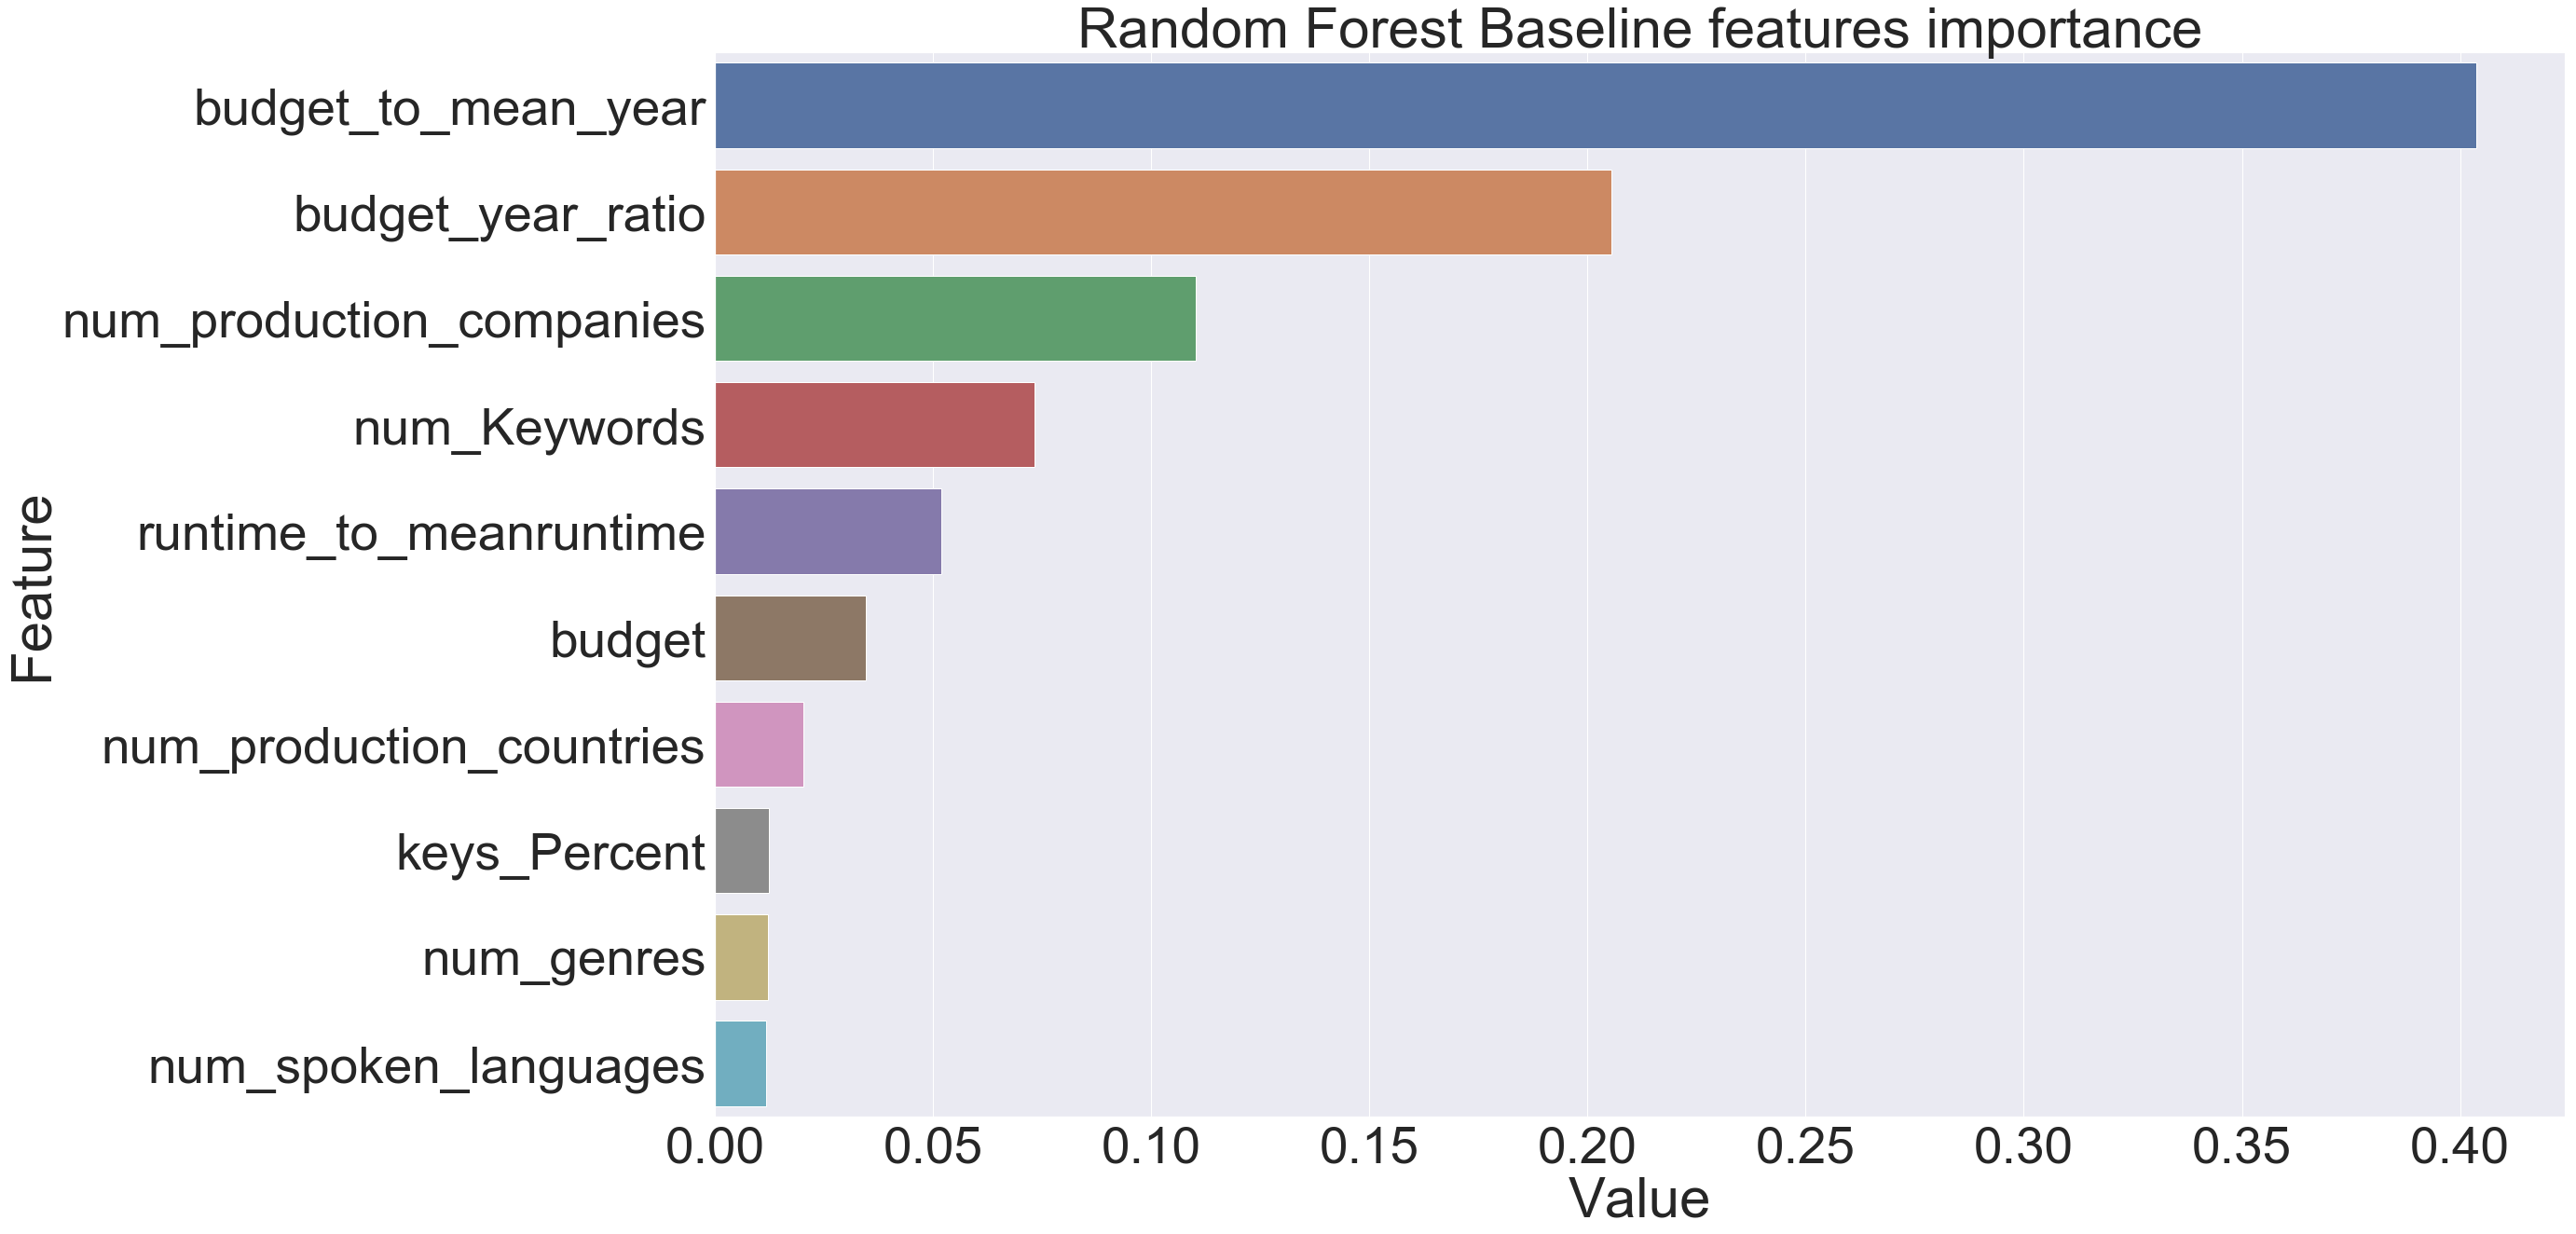

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        | -2.103    |  197.3    |  0.7267   |  53.71    |  12.29    |  666.7    |
|  2        | -2.15     |  96.67    |  0.4151   |  93.83    |  7.979    |  579.3    |
|  3        | -2.155    |  52.51    |  0.9203   |  77.42    |  2.938    |  859.9    |
|  4        | -2.182    |  107.2    |  0.9654   |  99.04    |  4.218    |  656.6    |
|  5        | -2.136    |  184.5    |  0.3136   |  69.24    |  3.997    |  790.0    |
|  6        | -2.131    |  190.2    |  0.7422   |  71.61    |  10.93    |  541.1    |
|  7        | -2.126    |  194.5    |  0.4982   |  75.49    |  7.415    |  447.4    |
|  8        | -2.196    |  31.1     |  0.219    |  73.21    |  12.93    |  679.0    |
|  9        | -2.15     |  167.1    |  0.5383   |  95.27    |  3.849    |  869.9    |
|  10       | -2.152    |  63.91    |  0.4213   |  96.

In [22]:
rf = RandomForestRegressor(n_estimators=50, random_state=123)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('The rmse of Random Forest Baseline is :', sqrt(mean_squared_error(y_test, y_pred)))
random_forest_after = sqrt(mean_squared_error(y_test, y_pred))


feature_imp = pd.DataFrame(sorted(zip(rf.feature_importances_,X_train.columns)), 
                               columns=['Value','Feature'])
plt.figure(figsize=(40, 20))
sns.set(font_scale = 5)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:10])
plt.title('Random Forest Baseline features importance')
plt.tight_layout()
plt.savefig('feaimp_rf.png')
plt.show()
del feature_imp

#Bayesian optimization
def bayesian_optimization(dataset, function, parameters):
    
    
    X_train, y_train, X_test, y_test = dataset
    n_iterations = 30
    gp_params = {"alpha": 1e-4}
    init_points = 12

    BO = BayesianOptimization(function, parameters)
    BO.maximize(n_iter=n_iterations, **gp_params, init_points = init_points)

    return BO.max

## for randomforest
def rfc_optimization(cv_splits):
    def function(n_estimators, max_depth, min_samples_split, max_features, min_samples_leaf): # make changes here to add more parameters 
        
        return cross_val_score(
               RandomForestRegressor(
                   n_estimators=int(max(n_estimators,0)),                                                               
                   max_depth=int(max(max_depth,1)),
                   min_samples_split=int(max(min_samples_split,2)), 
                   max_features = float(max(max_features,0.2)),
                   min_samples_leaf= int(max(min_samples_leaf,50)),
                   #oob_score = True,
                   
                   
                   n_jobs=-1, 
                   random_state=22  
                   ),  
               X=X_train, 
               y=y_train, 
               cv=cv_splits,
               scoring="neg_mean_squared_error",
               n_jobs=-1).mean()

    parameters = {"n_estimators": (100, 1000),
                  "max_depth": (1, 200), #quick note : consider 1 to 200 next time
                  "min_samples_split": (2, 15),
                  "max_features": (0.2, 1),
                  "min_samples_leaf": (50, 100),
                  #"oob_score": True
                  
                 }
    
    return function, parameters

#Train model using optimum parameters
def rftrain(X_train, y_train, X_test, y_test, function, parameters):
    dataset = (X_train, y_train, X_test, y_test)
    cv_splits = 10
    
    best_solution = bayesian_optimization(dataset, function, parameters)      
    params = best_solution["params"]

    model = RandomForestRegressor(
             n_estimators=int(max(params["n_estimators"], 0)),
             max_depth=int(max(params["max_depth"], 1)),
             min_samples_split=int(max(params["min_samples_split"], 2)), 
             max_features = float(max(params["max_features"], 0.2)),
             min_samples_leaf= int(max(params["min_samples_leaf"],50)),
             n_jobs=-1, 
             random_state=23,
             #oob_score = True
             )

    model.fit(X_train, y_train)
    
    return model


rffunc, rfparams = rfc_optimization(10)
rfmodel = rftrain(X_train, y_train, X_test, y_test, rffunc, rfparams)



y_pred = rfmodel.predict(X_test)
print('The rmse of bayesian optimize random forest is :', sqrt(mean_squared_error(y_test, y_pred)))
opt_random_forest_after = sqrt(mean_squared_error(y_test, y_pred))

## 3.3 XGBoost 

In [23]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('The rmse of XGBoost Baseline:', sqrt(mean_squared_error(y_test, y_pred)))
xgb_after = sqrt(mean_squared_error(y_test, y_pred))
eval_set = [(X_test, y_test)]
def xgb_optimization(cv_splits, eval_set):
    def function(eta, gamma, max_depth,n_estimators,min_child_weight):  
            return cross_val_score(
                   xgb.XGBRegressor(
                       n_estimators=int(max(n_estimators,50)),
                       objective="reg:linear",
                       learning_rate=max(eta, 0),
                       gamma=max(gamma, 0),
                       max_depth=max(int(max_depth), 1),   
                       min_child_weight=max(min_child_weight, 1),
                       #subsample = max(subsample, 0),
                       #colsample_bytree = max(colsample_bytree, 0),
                       #colsample_bylevel = max(colsample_bylevel, 0),

                       seed=42,
                       nthread=-1
                       ),  
                   X=X_train, 
                   y=y_train, 
                   cv=cv_splits,
                   scoring='neg_mean_squared_error',
                   fit_params={
                        "early_stopping_rounds": 200, 
                        "eval_metric": "rmse", 
                        "eval_set": eval_set},
                   n_jobs=-1).mean()

    parameters = {"eta": (0.07, 0.2),
                  "gamma": (0,2),
                  "max_depth": (1, 10),
                 "min_child_weight": (1, 10),
                 #"subsample": (0,1),
                 #"colsample_bytree": (0,1),
                  "n_estimators": (50,150), 
                  #"colsample_bylevel": (0,1)
                  
                 }
    
    return function, parameters

#Train model using optimum parameters
def xgbtrain(X_train, y_train, X_test, y_test, function, parameters):
    dataset = (X_train, y_train, X_test, y_test)
    cv_splits = 10
    
    best_solution = bayesian_optimization(dataset, function, parameters)      
    params = best_solution["params"]

    model = XGBRegressor(
             n_estimators=int(params["n_estimators"]),
             objective="reg:linear",
             learning_rate= params["eta"],
             gamma=int(params["gamma"]),
             max_depth=int(params["max_depth"]),
             min_child_weight=int(params["min_child_weight"]),
             #subsample=int(params["subsample"]),
             #colsample_bytree=int(params["colsample_bytree"]),
             #colsample_bylevel = int(params["colsample_bylevel"]),
             nthread=-1, 
             seed=42 
             )

    model.fit(X_train, y_train)
    
    return model


xgbfunction, xgbparameters = xgb_optimization(10, eval_set)
xgbmodel =xgbtrain(X_train, y_train, X_test, y_test, xgbfunction, xgbparameters)


y_pred = xgbmodel.predict(X_test)
print('The rmse of optimize XGBoost is :', sqrt(mean_squared_error(y_test, y_pred)))
opt_xgboost = sqrt(mean_squared_error(y_test, y_pred))

[17:13:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The rmse of XGBoost Baseline: 1.3993590940431013
|   iter    |  target   |    eta    |   gamma   | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------------------
|  1        | -1.849    |  0.1801   |  0.2746   |  6.672    |  1.932    |  110.0    |
|  2        | -1.726    |  0.1907   |  1.399    |  2.666    |  1.412    |  121.7    |
|  3        | -1.822    |  0.1411   |  1.002    |  7.686    |  7.004    |  104.3    |
|  4        | -1.816    |  0.1421   |  0.02582  |  7.053    |  1.081    |  55.73    |
|  5        | -1.813    |  0.08592  |  0.6941   |  8.495    |  7.102    |  51.19    |
|  6        | -1.79     |  0.07937  |  0.7869   |  6.456    |  8.455    |  59.32    |
|  7        | -2.133    |  0.1883   |  1.008    |  1.855    |  3.425    |  52.45    |
|  8        |

## 3.3 LightGBM

In [24]:
train_set = lgb.Dataset(X_train, label=y_train)
valid_set = lgb.Dataset(X_test, label=y_test)
params = {
        "objective" : "regression", 
        "metric" : "rmse", 
        "num_leaves" : 100, 
        "learning_rate" : 0.03, 
        "bagging_fraction" : 0.9,
        "bagging_seed" : 0, 
        "num_threads" : 4,
        "colsample_bytree" : 0.5,
        'min_data_in_leaf':1900, 
        'min_split_gain':0.00011,
        'lambda_l2':9
}

model = lgb.train(  params, 
                    train_set = train_set,
                    num_boost_round=9400,
                    early_stopping_rounds=200,
                    verbose_eval=100, 
                    valid_sets=[train_set,valid_set]
                  )


y_pred=model.predict(X_test, num_iteration=model.best_iteration)
print('The rmse of Baseline lightgbm is :', sqrt(mean_squared_error(y_test, y_pred)))
lgb_after = sqrt(mean_squared_error(y_test, y_pred))

def bayesion_opt_lgbm(X, y, init_iter=12, n_iters=30, random_state=11, seed = 101, num_iterations = 200):
    
    
    dtrain = lgb.Dataset(data=X, label=y)
      
      # Objective Function
    def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight, n_estimators, learning_rate, subsample, colsample_bytree):
        
        params = {'application':'regression','num_iterations': num_iterations, 
                         'early_stopping_round':50,
                        'metric':'l2'} # Default parameters 
       
                
        params["n_estimators"] = int(max(n_estimators, 10)) 
        params["learning_rate"] = float(max(learning_rate, 0 ))
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['subsample'] = max(subsample, 0)
        params['colsample_bytree'] = max(colsample_bytree, 0)
        
       
             
            
            
        cv_results = lgb.cv(params, dtrain, nfold=5, seed=seed, stratified=False,
                                  verbose_eval =None, metrics=['l2'])
              # print(cv_results)
        return -np.min(cv_results['l2-mean'])
    
    
      # Domain space-- Range of hyperparameters 
    pds = {     'num_leaves': (10, 100),
                'feature_fraction': (0.1, 0.9),
                'bagging_fraction': (0.8, 1),
                'max_depth': (1, 2000),
                'min_split_gain': (0.001, 0.1),
                'min_child_weight': (10, 25),
                'n_estimators' : (10,10000),
                "learning_rate": (0.001, 0.4),
                "subsample": (0, 1),
                "colsample_bytree" : (0, 1)
                
                }

      # Surrogate model
    optimizer = BayesianOptimization(hyp_lgbm, pds, random_state=random_state)

      # Optimize
    optimizer.maximize(init_points=init_iter, n_iter=n_iters)
    return optimizer.max

opt_params = bayesion_opt_lgbm(X, y, init_iter=12, n_iters=30, random_state=77, seed = 101, num_iterations = 200)

opt_params


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.76641	valid_1's rmse: 1.80979
[200]	training's rmse: 1.72999	valid_1's rmse: 1.80566
[300]	training's rmse: 1.72572	valid_1's rmse: 1.81066
Early stopping, best iteration is:
[142]	training's rmse: 1.74122	valid_1's rmse: 1.80336
The rmse of Baseline lightgbm is : 1.803357117496274
|   iter    |  target   | baggin... | colsam... | featur... | learni... | max_depth | min_ch... | min_sp... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  1        | -1.881    |  0.9838   |  0.6422   |  0.703    |  0.05659  |  175.6    |  21.82    |  0.03329  |  5.415e+0 |  31.62    |  0.5454   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  2        | -1.89     |  0.8801   |  0.7152   |  0.7693   |  0.2358   |  593.0    |  14.22    |  0.07085  |  4.232e+0 |  15.16    |  0.747    |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  3        | -1.938    |  0.8905   |  0.1758   |  0.1395   |  0.1177   |  134.5    |  21.27    |  0.007313 |  4.325e+0 |  42.78    |  0.152    |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  4        | -2.023    |  0.9093   |  0.4433   |  0.1288   |  0.3293   |  547.3    |  12.53    |  0.06479  |  1.084e+0 |  41.79    |  0.3857   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  5        | -1.89     |  0.8891   |  0.9771   |  0.6835   |  0.1256   |  1.79e+03 |  21.75    |  0.02694  |  3.102e+0 |  21.65    |  0.4222   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  6        | -1.917    |  0.988    |  0.367    |  0.4478   |  0.3669   |  1.895e+0 |  13.82    |  0.07126  |  509.3    |  22.13    |  0.5065   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  7        | -1.897    |  0.9178   |  0.3269   |  0.2159   |  0.1038   |  1.715e+0 |  20.26    |  0.09986  |  3.201e+0 |  50.81    |  0.8676   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  8        | -1.876    |  0.9277   |  0.3319   |  0.5336   |  0.04582  |  1.633e+0 |  13.31    |  0.05198  |  5.266e+0 |  34.94    |  0.9044   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  9        | -1.873    |  0.8841   |  0.949    |  0.7292   |  0.1931   |  24.83    |  10.9     |  0.08275  |  4.052e+0 |  14.78    |  0.2596   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  10       | -1.918    |  0.8562   |  0.9433   |  0.8149   |  0.08171  |  201.6    |  18.6     |  0.07479  |  6.012e+0 |  91.83    |  0.9386   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  11       | -1.887    |  0.9123   |  0.8908   |  0.35     |  0.3087   |  428.1    |  14.33    |  0.02807  |  2.493e+0 |  11.3     |  0.6091   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  12       | -1.912    |  0.9724   |  0.2591   |  0.7935   |  0.1712   |  321.6    |  10.85    |  0.04286  |  7.363e+0 |  52.93    |  0.7007   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  13       | -1.903    |  1.0      |  1.0      |  0.9      |  0.4      |  2e+03    |  10.0     |  0.1      |  1e+04    |  10.0     |  1.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  14       | -2.002    |  1.0      |  1.0      |  0.9      |  0.4      |  1.0      |  10.0     |  0.1      |  1e+04    |  10.0     |  1.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  15       | -1.864    |  1.0      |  1.0      |  0.8818   |  0.3909   |  2e+03    |  10.0     |  0.09774  |  7.837e+0 |  10.0     |  0.9772   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  16       | -2.002    |  1.0      |  1.0      |  0.9      |  0.4      |  1.0      |  10.0     |  0.1      |  10.0     |  10.0     |  1.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  17       | -2.107    |  0.8175   |  0.08762  |  0.1      |  0.03596  |  1.086e+0 |  10.0     |  0.009675 |  8.899e+0 |  10.0     |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  18       | -5.421    |  0.8      |  0.0      |  0.1      |  0.001    |  2e+03    |  14.95    |  0.001    |  6.53e+03 |  10.0     |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  19       | -1.902    |  1.0      |  1.0      |  0.9      |  0.4      |  2e+03    |  25.0     |  0.001    |  4.361e+0 |  10.0     |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  20       | -2.087    |  1.0      |  0.0      |  0.1      |  0.4      |  2e+03    |  10.0     |  0.1      |  1.747e+0 |  100.0    |  1.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  21       | -2.0      |  1.0      |  1.0      |  0.9      |  0.4      |  1.0      |  25.0     |  0.1      |  8.473e+0 |  100.0    |  1.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  22       | -2.041    |  1.0      |  1.0      |  0.9      |  0.4      |  2e+03    |  25.0     |  0.1      |  8.752e+0 |  100.0    |  1.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  23       | -5.417    |  0.8      |  1.0      |  0.1      |  0.001    |  1.085e+0 |  25.0     |  0.001    |  10.0     |  100.0    |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  24       | -4.991    |  1.0      |  0.0      |  0.9      |  0.001    |  1.0      |  25.0     |  0.09215  |  1.73e+03 |  100.0    |  1.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  25       | -1.881    |  0.9069   |  1.0      |  0.5516   |  0.3635   |  975.9    |  14.46    |  0.1      |  2.875e+0 |  10.0     |  0.3414   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  26       | -5.421    |  0.8      |  0.0      |  0.1      |  0.001    |  327.8    |  12.8     |  0.001    |  3.236e+0 |  10.0     |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  27       | -1.915    |  0.9901   |  1.0      |  0.3624   |  0.4      |  911.4    |  13.15    |  0.1      |  2.408e+0 |  10.0     |  0.8062   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  28       | -2.087    |  0.8423   |  0.0      |  0.1      |  0.4      |  1.425e+0 |  10.0     |  0.1      |  2.698e+0 |  100.0    |  1.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  29       | -1.914    |  1.0      |  0.03632  |  0.9      |  0.2896   |  1.513e+0 |  17.96    |  0.1      |  4.699e+0 |  19.47    |  0.02333  |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  30       | -1.955    |  1.0      |  0.757    |  0.9      |  0.4      |  799.3    |  15.44    |  0.1      |  4.885e+0 |  24.09    |  0.8363   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  31       | -1.892    |  0.9377   |  0.6737   |  0.7216   |  0.07313  |  776.6    |  17.52    |  0.084    |  5.576e+0 |  69.14    |  0.8634   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  32       | -1.948    |  0.9287   |  0.4962   |  0.83     |  0.4      |  1.502e+0 |  16.46    |  0.1      |  8.218e+0 |  24.61    |  0.5704   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  33       | -1.962    |  1.0      |  0.0      |  0.7934   |  0.285    |  646.1    |  15.52    |  0.1      |  8.02e+03 |  55.02    |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  34       | -1.902    |  1.0      |  1.0      |  0.9      |  0.4      |  1.406e+0 |  25.0     |  0.001    |  4.016e+0 |  10.0     |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  35       | -5.414    |  0.8017   |  0.2352   |  0.1      |  0.001    |  1.601e+0 |  19.94    |  0.001    |  9.477e+0 |  100.0    |  0.2057   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  36       | -5.414    |  0.8      |  0.0      |  0.1      |  0.001    |  1.074e+0 |  10.0     |  0.1      |  4.411e+0 |  100.0    |  1.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  37       | -1.903    |  1.0      |  1.0      |  0.9      |  0.4      |  335.7    |  10.0     |  0.1      |  4.083e+0 |  10.0     |  0.1487   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  38       | -1.905    |  0.8893   |  0.691    |  0.7365   |  0.1477   |  414.3    |  18.84    |  0.05718  |  5.689e+0 |  68.16    |  0.8318   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  39       | -1.886    |  0.9855   |  0.2716   |  0.7319   |  0.09816  |  563.9    |  18.26    |  0.03979  |  5.237e+0 |  33.98    |  0.8397   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  40       | -1.907    |  1.0      |  0.6392   |  0.9      |  0.3697   |  1.849e+0 |  21.11    |  0.05716  |  4.851e+0 |  10.0     |  0.1974   |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  41       | -1.902    |  1.0      |  1.0      |  0.9      |  0.4      |  1.777e+0 |  25.0     |  0.001    |  3.913e+0 |  10.0     |  0.0      |


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



|  42       | -1.889    |  0.8665   |  0.9369   |  0.4985   |  0.06769  |  177.6    |  23.21    |  0.06621  |  5.414e+0 |  34.42    |  0.1354   |


{'target': -1.8641144850030944,
 'params': {'bagging_fraction': 1.0,
  'colsample_bytree': 1.0,
  'feature_fraction': 0.8817721405492712,
  'learning_rate': 0.390908855098949,
  'max_depth': 2000.0,
  'min_child_weight': 10.000000001086345,
  'min_split_gain': 0.09774430239297233,
  'n_estimators': 7836.58516042702,
  'num_leaves': 10.0,
  'subsample': 0.977215175686589}}

In [25]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict

params =  {'bagging_fraction': 1.0,
  'colsample_bytree': 1.0,
  'feature_fraction': 0.9,
  'learning_rate': 0.4,
  'max_depth': 2000,
  'min_child_weight': 10.0,
  'min_split_gain': 0.1,
  'n_estimators': 10000.0,
  'num_leaves': 10,
  'subsample': 0.0}


print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=lgb_eval)



print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of optimize lightgbm is :', sqrt(mean_squared_error(y_test, y_pred)))
opt_lgb_after = sqrt(mean_squared_error(y_test, y_pred))



Starting training...


C:\Users\chava\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Starting predicting...
The rmse of optimize lightgbm is : 1.097545801252295


# 4. Ensembling top two models

Lets try if can improve results using simple ensembling techniques

In [26]:
#Top Models
print("Random Forest Baseline :", random_forest_after)
print("Optimize Lightgbm :", opt_lgb_after)
opt_lightgbm = y_pred   #1.09
random_forest_base = rf.predict(X_test) #0.95

def ensembling(model1_prediction, model2_prediction):
    for weight1 in np.arange(0,1,0.05):
        smallest = 100
        tmp10 = (weight1 * model1_prediction) + ((1-weight1) * model2_prediction)
        result = sqrt(mean_squared_error(y_test, tmp10))
        if result < smallest:
            smallest = result
            wt1 = weight1
            wt2 = (1-weight1)
    return smallest, wt1, wt2


best_rmse, rf_weight, gbm_weight =ensembling(random_forest_base, opt_lightgbm)
print ("RMSE by ensembling top individual models: ", best_rmse)

Random Forest Baseline : 0.9562620949022258
Optimize Lightgbm : 1.097545801252295
RMSE by ensembling top individual models:  0.9568998331900027
